In [398]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import silhouette_score
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.cluster import KMeans



In [399]:
# Load datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")





In [400]:
# Aggregate transaction data for RFM metrics
rfm_data = transactions.groupby("CustomerID").agg({
    "TransactionDate": lambda x: (pd.Timestamp.now() - pd.to_datetime(x.max())).days,  # Recency
    "TransactionID": "count",  # Frequency
    "TotalValue": "sum"  # Monetary
}).reset_index()

rfm_data.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]

In [401]:
rfm_data

,CustomerID,Recency,Frequency,Monetary
0,C0001,86,5,3354.52
1,C0002,56,4,1862.74
2,C0003,156,4,2725.38
3,C0004,35,8,5354.88
4,C0005,85,3,2034.24
...,...,...,...,...
194,C0196,44,4,4982.88
195,C0197,31,3,1928.65
196,C0198,115,2,931.83
197,C0199,94,4,1979.28


In [402]:
rfm_data = rfm_data.set_index('CustomerID')


In [403]:
rfm_data.describe()

,Recency,Frequency,Monetary
count,199.000000,199.000000,199.000000
mean,104.663317,5.025126,3467.314372
std,70.901783,2.198340,1832.677958
min,30.000000,1.000000,82.360000
25%,48.000000,3.000000,2162.040000
50%,89.000000,5.000000,3137.660000
75%,135.000000,6.000000,4770.225000
max,391.000000,11.000000,10673.870000


In [404]:
def plot_boxplot(data):
  fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(10,4))
  for idx,feature in enumerate(data.columns):
    sns.boxplot(data=data,x=feature,ax=axes[idx], palette="Blues")
    axes[idx].set_xlabel(f'{feature}',fontsize = 10)
    axes[idx].set_title(f'Box Plot of {feature}')
  plt.tight_layout()
  plt.show()

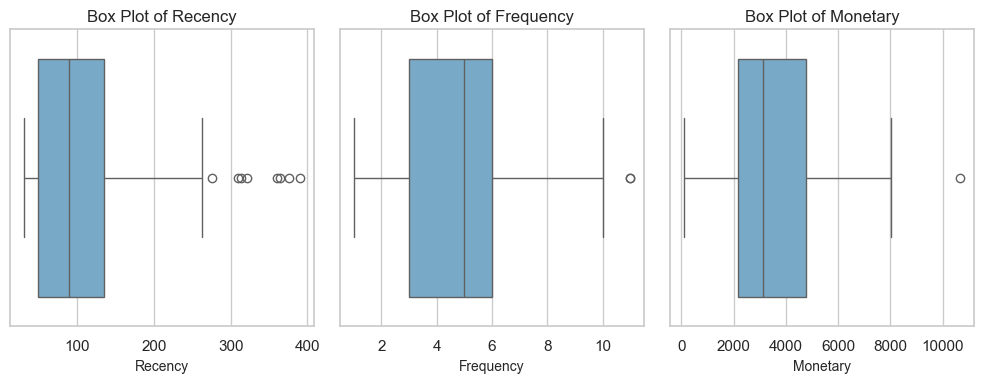

In [405]:
plot_boxplot(rfm_data)

In [406]:
def plot_distribution(data):
    fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(10,4))
    for idx,feature in enumerate(data.columns):
        sns.histplot(data=data,x=feature, palette="Blues",ax=axes[idx],kde=True)
        axes[idx].set_xlabel(f'{feature}',fontsize = 10)
        axes[idx].set_title(f'Box Plot of {feature}')
    plt.tight_layout()
    plt.show()

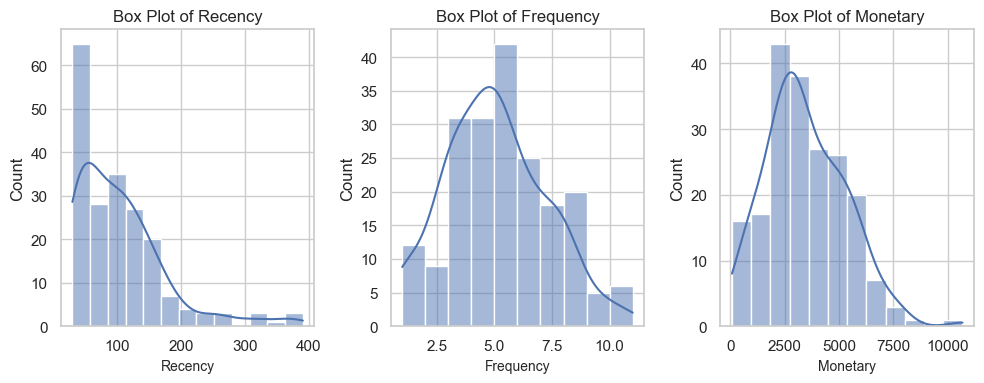

In [407]:
plot_distribution(rfm_data)

In [408]:
rfm_data['Recency'] = np.log1p(rfm_data['Recency'])
rfm_data['Frequency'] = np.log1p(rfm_data['Frequency'])
rfm_data['Monetary'] = np.log1p(rfm_data['Monetary'])

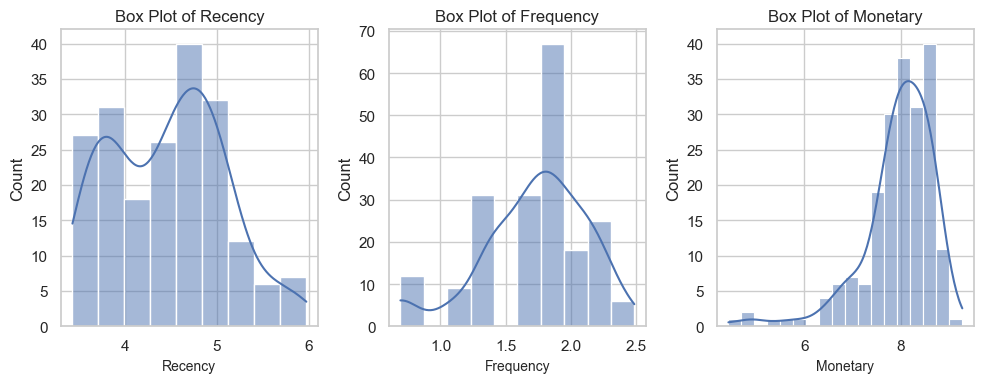

In [409]:
plot_distribution(rfm_data)

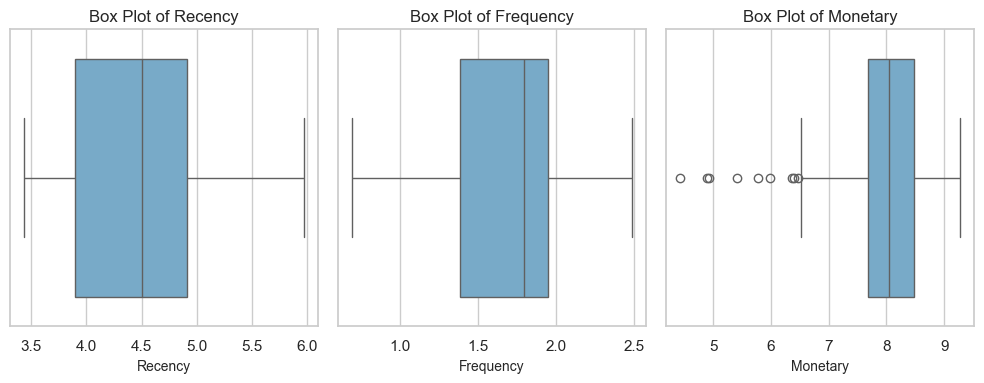

In [410]:
plot_boxplot(rfm_data)


In [411]:
rfm_data.describe()

,Recency,Frequency,Monetary
count,199.000000,199.000000,199.000000
mean,4.466972,1.720721,7.954449
std,0.618814,0.408478,0.744989
min,3.433987,0.693147,4.423169
25%,3.891820,1.386294,7.679209
50%,4.499810,1.791759,8.051551
75%,4.912628,1.945910,8.470355
max,5.971262,2.484907,9.275648


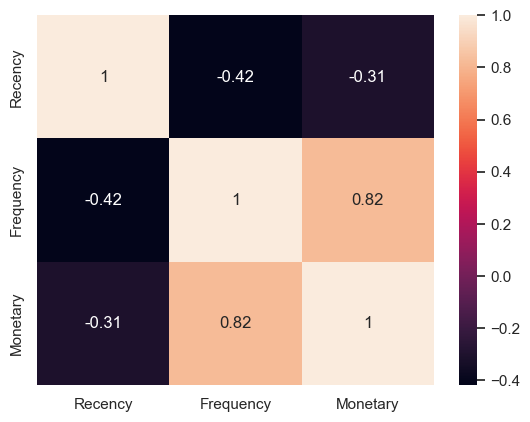

In [412]:
sns.heatmap(rfm_data.corr(),annot=True)
plt.show()

In [413]:
def IQR_outlier(data,col):
 Q1 = data[col].quantile(0.25)
 Q3 = data[col].quantile(0.75)
 IQR = Q3 - Q1
 lower_bound = Q1 - 1.5*IQR
 upper_bound = Q3 + 1.5*IQR
 outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
 print(f"Number of Outliers in {col} : {outliers.shape[0]}")
 return lower_bound,upper_bound

In [414]:
lower_bound,upper_bound = IQR_outlier(rfm_data,'Frequency')
rfm = rfm_data[(rfm_data['Frequency'] > lower_bound) &(rfm_data['Frequency'] < upper_bound)]

Number of Outliers in Frequency : 0


In [415]:
lower_bound,upper_bound = IQR_outlier(rfm,'Monetary')
rfm = rfm[(rfm['Monetary'] > lower_bound) &(rfm['Monetary'] < upper_bound)]

Number of Outliers in Monetary : 9


In [416]:
rfm.describe()

,Recency,Frequency,Monetary
count,190.000000,190.000000,190.000000
mean,4.435144,1.765747,8.064654
std,0.587171,0.357037,0.536285
min,3.433987,0.693147,6.513230
25%,3.891820,1.609438,7.756065
50%,4.471622,1.791759,8.081009
75%,4.867534,2.079442,8.477859
max,5.971262,2.484907,9.275648


In [417]:
rfm["recency_score"] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])


rfm["frequency_score"] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])


rfm["monetary_score"] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])


rfm["RFM_SCORE"] = (rfm['recency_score'].astype(str) +
                    rfm['frequency_score'].astype(str))

In [418]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)
rfm.reset_index(inplace=True)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
0,C0001,4.465908,1.791759,8.118362,3,2,3,32,about_to_sleep
1,C0002,4.043051,1.609438,7.530341,4,2,1,42,potential_loyalists
2,C0003,5.056246,1.609438,7.910730,1,2,2,12,hibernating
3,C0004,3.583519,2.197225,8.585950,5,5,5,55,champions
4,C0005,4.454347,1.386294,7.618369,3,1,1,31,about_to_sleep


In [419]:
segments_count = rfm.groupby("segment").agg({"CustomerID": "count"})
segments_count.reset_index(inplace=True)
segments_count.columns = ['segment', 'count']
segments_count.head(15)

,segment,count
0,about_to_sleep,15
1,at_Risk,25
2,cant_loose,11
3,champions,20
4,hibernating,40
5,loyal_customers,30
6,need_attention,8
7,new_customers,2
8,potential_loyalists,32
9,promising,7


In [420]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)
rfm.reset_index(inplace=True)
rfm.head()

,index,CustomerID,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
0,0,C0001,4.465908,1.791759,8.118362,3,2,3,32,about_to_sleep
1,1,C0002,4.043051,1.609438,7.530341,4,2,1,42,potential_loyalists
2,2,C0003,5.056246,1.609438,7.910730,1,2,2,12,hibernating
3,3,C0004,3.583519,2.197225,8.585950,5,5,5,55,champions
4,4,C0005,4.454347,1.386294,7.618369,3,1,1,31,about_to_sleep


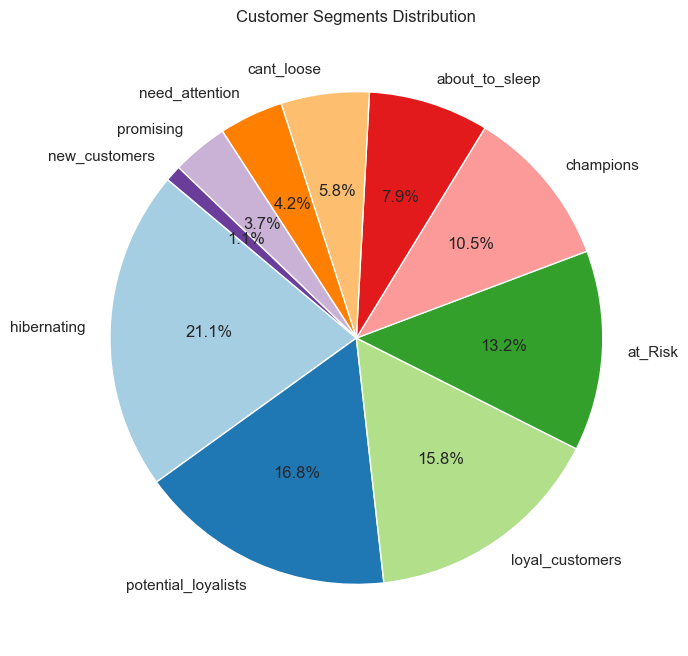

In [421]:
segment_counts = rfm['segment'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Customer Segments Distribution')
plt.show()

In [422]:
rfm

,index,CustomerID,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
0,0,C0001,4.465908,1.791759,8.118362,3,2,3,32,about_to_sleep
1,1,C0002,4.043051,1.609438,7.530341,4,2,1,42,potential_loyalists
2,2,C0003,5.056246,1.609438,7.910730,1,2,2,12,hibernating
3,3,C0004,3.583519,2.197225,8.585950,5,5,5,55,champions
4,4,C0005,4.454347,1.386294,7.618369,3,1,1,31,about_to_sleep
...,...,...,...,...,...,...,...,...,...,...
185,185,C0196,3.806662,1.609438,8.513964,5,2,4,52,potential_loyalists
186,186,C0197,3.465736,1.386294,7.565094,5,2,1,52,potential_loyalists
187,187,C0198,4.753590,1.098612,6.838223,2,1,1,21,hibernating
188,188,C0199,4.553877,1.609438,7.590994,3,2,1,32,about_to_sleep


In [423]:
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(rfm.iloc[:,2:5])

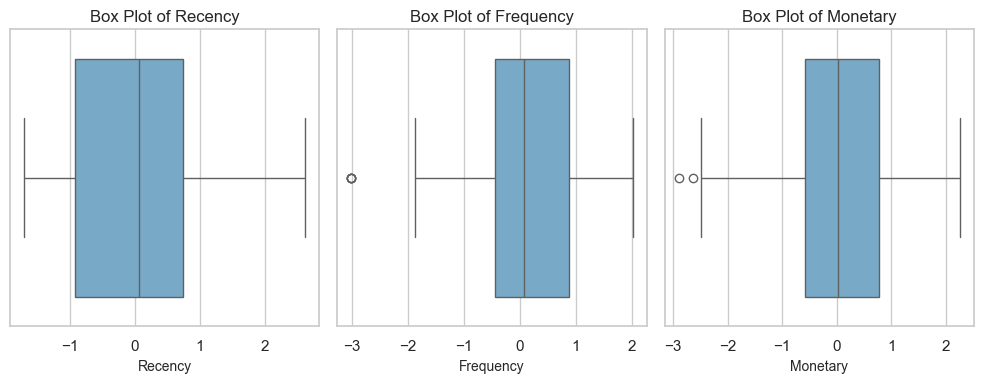

In [424]:
plot_boxplot(pd.DataFrame(df_scaled, columns=['Recency', 'Frequency', 'Monetary'])  )

In [425]:
df_scaled = pd.DataFrame(df_scaled, columns=['Recency', 'Frequency', 'Monetary'])

df_scaled.head()

,Recency,Frequency,Monetary
0,0.052532,0.073049,0.100413
1,-0.669530,-0.438952,-0.998956
2,1.060581,-0.438952,-0.287777
3,-1.454218,1.211688,0.974619
4,0.032791,-1.065590,-0.834377


In [426]:
df_scaled["CustomerID"] = rfm['CustomerID']
df_scaled = df_scaled.set_index("CustomerID")

In [427]:
df_scaled

,Recency,Frequency,Monetary
CustomerID,,,
C0001,0.052532,0.073049,0.100413
C0002,-0.669530,-0.438952,-0.998956
C0003,1.060581,-0.438952,-0.287777
C0004,-1.454218,1.211688,0.974619
C0005,0.032791,-1.065590,-0.834377
...,...,...,...
C0196,-1.073182,-0.438952,0.840033
C0197,-1.655342,-1.065590,-0.933981
C0198,0.543772,-1.873467,-2.292943


In [428]:
inertia = []
score = []
for i in range(2,15):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)
    score.append(silhouette_score(df_scaled,kmeans.labels_))

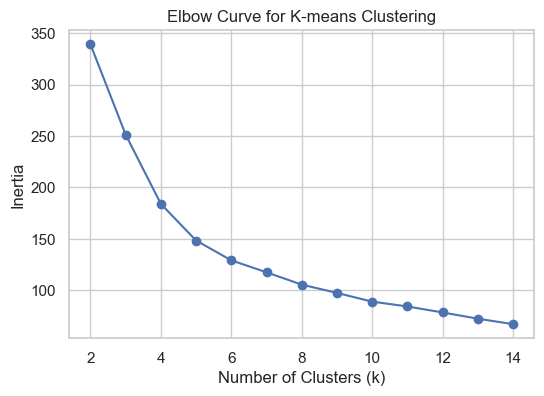

In [429]:
plt.figure(figsize=(6, 4))
plt.plot(range(2, 15), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve for K-means Clustering')
plt.show()

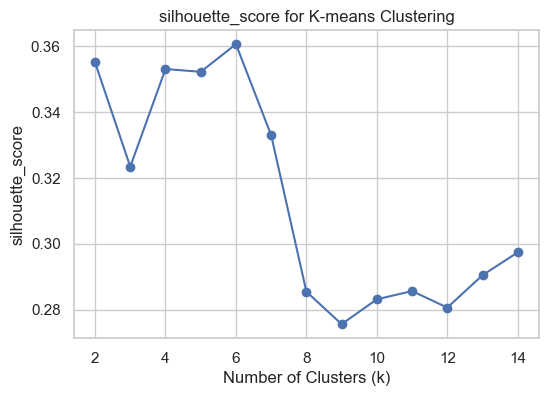

In [430]:
plt.figure(figsize=(6, 4))
plt.plot(range(2, 15), score, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('silhouette_score')
plt.title('silhouette_score for K-means Clustering')
plt.grid(True)
plt.show()

In [431]:
kmeans = KMeans(n_clusters=4, random_state=14)
kmeans.fit(df_scaled)
rfm1 = pd.DataFrame()
rfm1 = rfm.loc[:,["Recency","Frequency","Monetary"]]
rfm1['Cluster'] = kmeans.labels_

In [432]:
# Assuming `df_scaled` is your preprocessed data and `kmeans.labels_` are the cluster labels
db_index = davies_bouldin_score(df_scaled, kmeans.labels_)
silhouette_avg = silhouette_score(df_scaled, kmeans.labels_)

print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette_avg}")


Davies-Bouldin Index: 0.8753482228844133
Silhouette Score: 0.35306891019600023


In [433]:
rfm1.head()

,Recency,Frequency,Monetary,Cluster
0,4.465908,1.791759,8.118362,0
1,4.043051,1.609438,7.530341,2
2,5.056246,1.609438,7.910730,0
3,3.583519,2.197225,8.585950,1
4,4.454347,1.386294,7.618369,3


In [434]:
avg_clusters = rfm1.groupby('Cluster').mean()
avg_clusters = avg_clusters.reset_index()
avg_clusters

,Cluster,Recency,Frequency,Monetary
0,0,4.829446,1.840714,8.257960
1,1,3.930357,2.156831,8.631618
2,2,3.877958,1.669357,7.838748
3,3,4.946513,1.259583,7.263720


In [435]:
cluster_label = {
    0: 'Champions',        # High Monetary value and moderate Frequency
    1: 'Loyal Customers',   # Moderate values across all metrics
    2: 'Hibernating',       # Moderate Recency and low Frequency
    3: 'At Risk'          # High Recency and low Frequency
}

rfm1['Cluster Labels'] = rfm1['Cluster'].map(cluster_label)


In [436]:
rfm1.head()

,Recency,Frequency,Monetary,Cluster,Cluster Labels
0,4.465908,1.791759,8.118362,0,Champions
1,4.043051,1.609438,7.530341,2,Hibernating
2,5.056246,1.609438,7.910730,0,Champions
3,3.583519,2.197225,8.585950,1,Loyal Customers
4,4.454347,1.386294,7.618369,3,At Risk


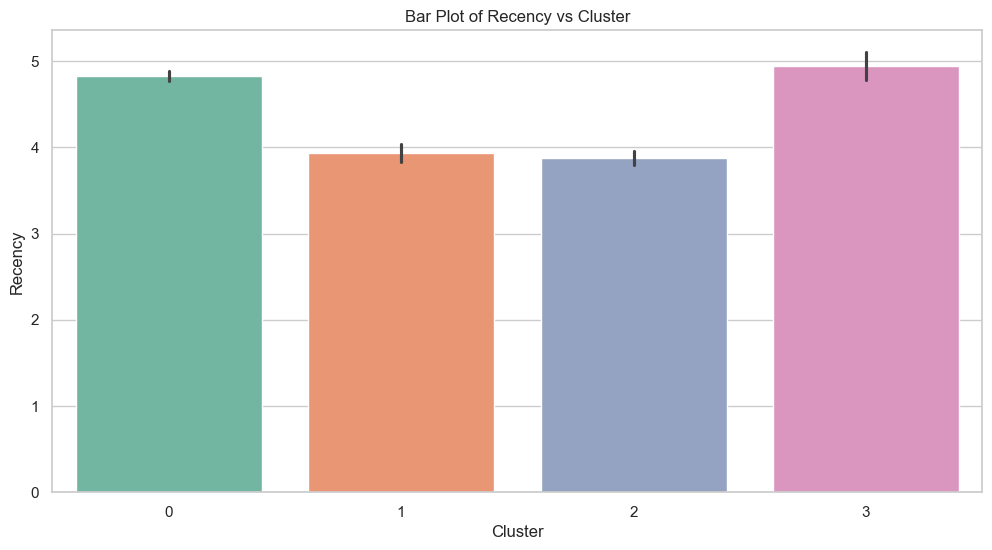

In [437]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Cluster', y='Recency', data=rfm1, palette='Set2')
plt.title('Bar Plot of Recency vs Cluster')
plt.xlabel('Cluster')
plt.ylabel('Recency')
plt.show()

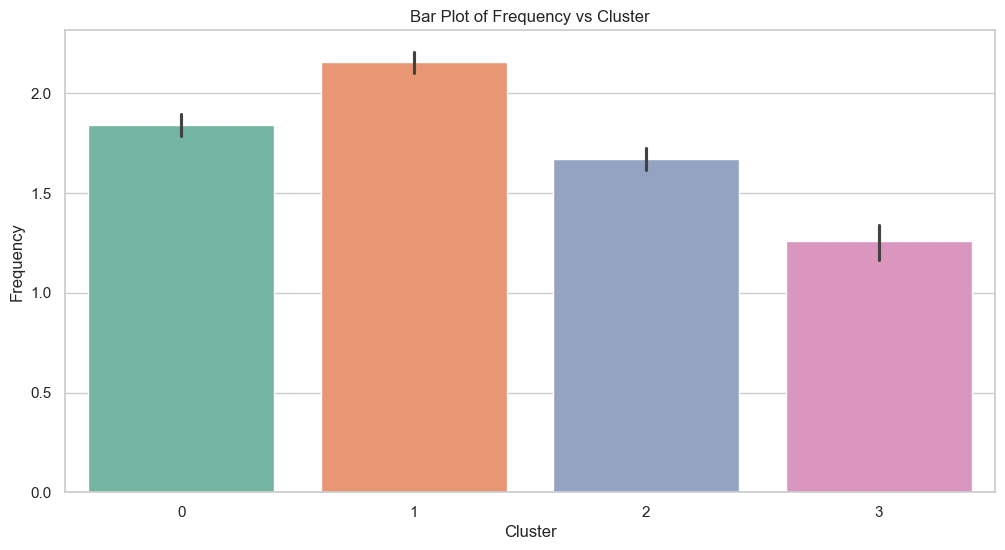

In [438]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Cluster', y='Frequency', data=rfm1, palette='Set2')
plt.title('Bar Plot of Frequency vs Cluster')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.show()

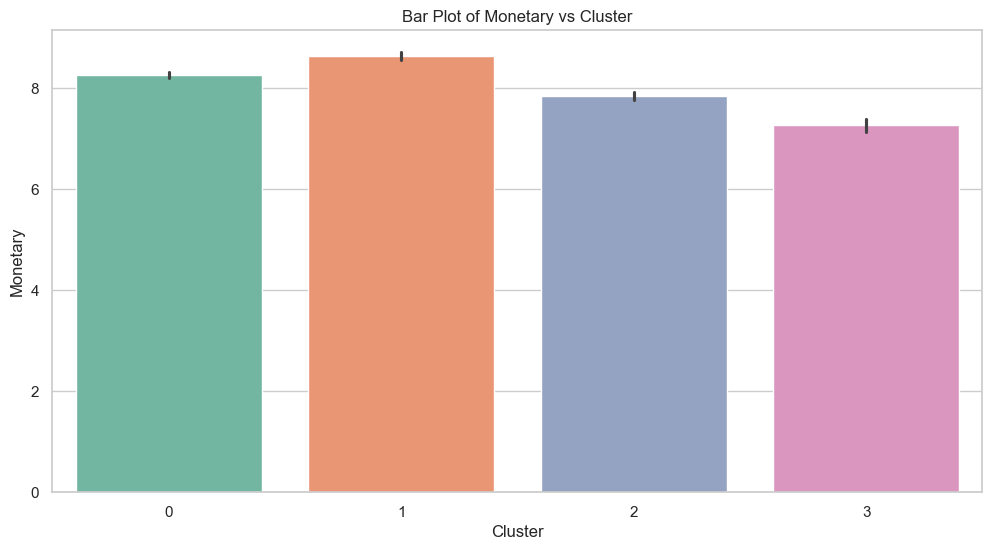

In [439]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Cluster', y='Monetary', data=rfm1, palette='Set2')
plt.title('Bar Plot of Monetary vs Cluster')
plt.xlabel('Cluster')
plt.ylabel('Monetary')
plt.show()

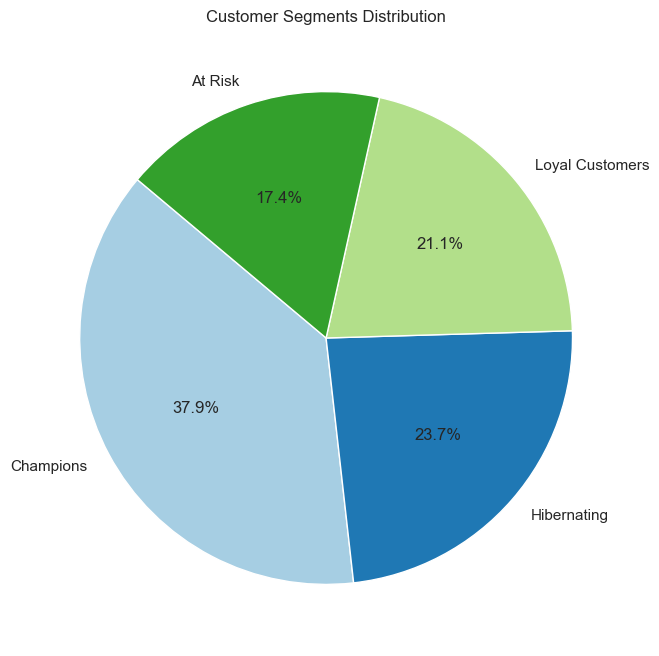

In [440]:
segment_counts = rfm1['Cluster Labels'].value_counts()

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title('Customer Segments Distribution')
plt.show()

In [441]:
rfm1

,Recency,Frequency,Monetary,Cluster,Cluster Labels
0,4.465908,1.791759,8.118362,0,Champions
1,4.043051,1.609438,7.530341,2,Hibernating
2,5.056246,1.609438,7.910730,0,Champions
3,3.583519,2.197225,8.585950,1,Loyal Customers
4,4.454347,1.386294,7.618369,3,At Risk
...,...,...,...,...,...
185,3.806662,1.609438,8.513964,2,Hibernating
186,3.465736,1.386294,7.565094,2,Hibernating
187,4.753590,1.098612,6.838223,3,At Risk
188,4.553877,1.609438,7.590994,2,Hibernating


# Prediction



In [442]:
def predictions(data):
 X_data = std_scaler.transform(data)
 pred = kmeans.predict(X_data)
 return pred

In [443]:
def customer_segmentation(Recency, Frequency, Monetary):
 print("Customer Segmentation")
 data_recency = np.log1p(Recency)
 data_frequency = np.log1p(Frequency)
 data_monetary = np.log1p(Monetary)
 data = pd.DataFrame({'Recency': [data_recency], 'Frequency': [data_frequency], 'Monetary': [data_monetary]})
 pred = predictions(data)
 print(f"The Customer belongs to {cluster_label[pred[0]]}")

In [444]:
customer_segmentation(50, 100, 200)

Customer Segmentation
The Customer belongs to Loyal Customers


In [445]:
rfm1[rfm1['Cluster Labels']=='At Risk'].head()

,Recency,Frequency,Monetary,Cluster,Cluster Labels
4,4.454347,1.386294,7.618369,3,At Risk
6,5.049856,1.386294,7.855862,3,At Risk
8,4.682131,1.386294,6.799613,3,At Risk
13,4.867534,1.098612,7.054864,3,At Risk
18,5.899897,0.693147,6.828073,3,At Risk


In [446]:
customer_segmentation(1000, 2000, 50)

Customer Segmentation
The Customer belongs to Loyal Customers


In [447]:
customer_segmentation(5.899897,	0.693147,	6.828073)

Customer Segmentation
The Customer belongs to At Risk


In [ ]:

pca = PCA(n_components=2)
features_2d = pca.fit_transform(df_scaled)


In [450]:

# Add PCA components to the DataFrame
rfm = df_scaled.copy()
rfm["PCA1"] = features_2d[:, 0]
rfm["PCA2"] = features_2d[:, 1]

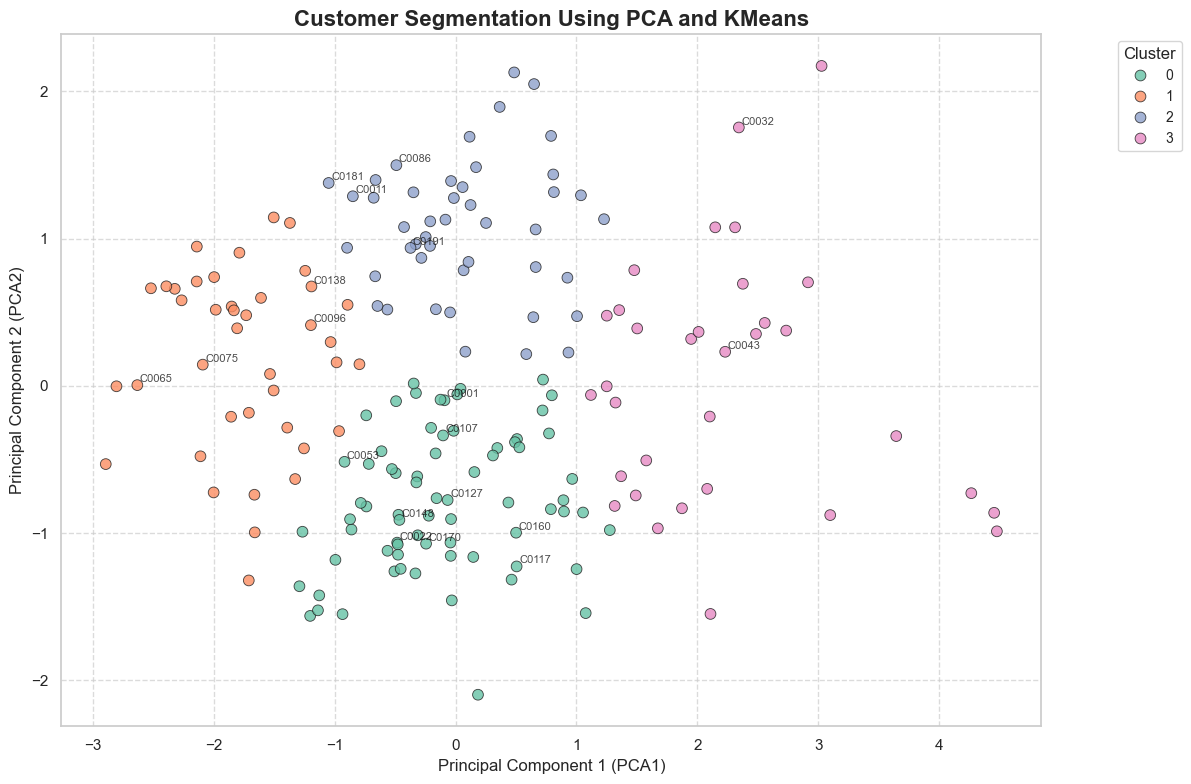

In [ ]:
rfm["Cluster"] = kmeans.fit_predict(df_scaled)


plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    x="PCA1",
    y="PCA2",
    hue="Cluster",  # Cluster
    data=rfm,
    palette="Set2",
    s=60,  # Size of points
    alpha=0.8,
    edgecolor="k",
)



# Add CustomerID annotations to specific points if necessary
for i in range(len(rfm)):
    if i % 10 == 0:
        plt.text(
            x=rfm["PCA1"].iloc[i] + 0.02,
            y=rfm["PCA2"].iloc[i] + 0.02,
            s=rfm.index[i],
            fontsize=8,
            color="black",
            alpha=0.7,
        )

# Add plot title and labels
plt.title("Customer Segmentation Using PCA and KMeans", fontsize=16, fontweight="bold")
plt.xlabel("Principal Component 1 (PCA1)", fontsize=12)
plt.ylabel("Principal Component 2 (PCA2)", fontsize=12)

# Adjust legend for clarity
plt.legend(
    title="Cluster",
    title_fontsize=12,
    fontsize=10,
    loc="upper right",
    bbox_to_anchor=(1.15, 1),
)

# Display grid for better visualization
plt.grid(True, linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

